Training...
Episode 100, reward: -268.09999999999883, eps: 0.995
Episode 200, reward: -243.6999999999984, eps: 0.990
Episode 300, reward: -286.4999999999996, eps: 0.985
Episode 400, reward: -285.6999999999997, eps: 0.980
Episode 500, reward: -334.9000000000003, eps: 0.975
Episode 600, reward: -259.29999999999853, eps: 0.970
Episode 700, reward: -259.2999999999987, eps: 0.966
Episode 800, reward: -242.89999999999813, eps: 0.961
Episode 900, reward: -283.69999999999936, eps: 0.956
Episode 1000, reward: -282.49999999999955, eps: 0.951
Episode 1100, reward: -256.0999999999984, eps: 0.946
Episode 1200, reward: -274.49999999999915, eps: 0.942
Episode 1300, reward: -286.49999999999955, eps: 0.937
Episode 1400, reward: -284.8999999999996, eps: 0.932
Episode 1500, reward: -234.09999999999835, eps: 0.928
Episode 1600, reward: -258.0999999999985, eps: 0.923
Episode 1700, reward: -261.2999999999987, eps: 0.919
Episode 1800, reward: -275.2999999999991, eps: 0.914
Episode 1900, reward: -278.89999999

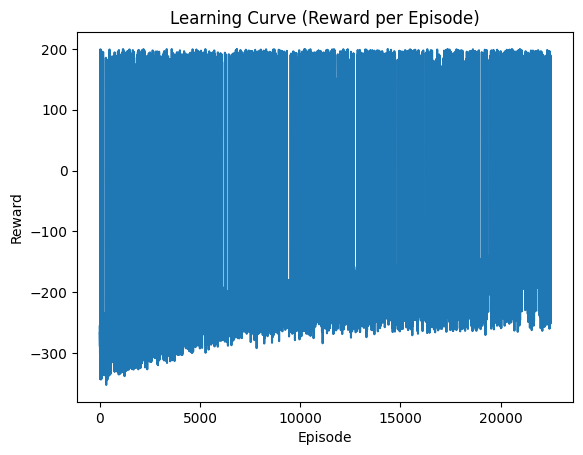


Demo of trained agent...



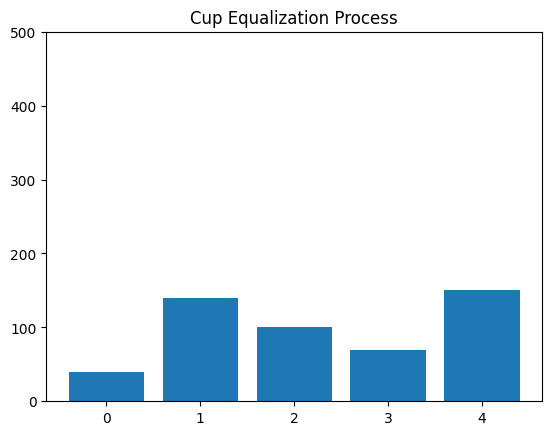

In [16]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.animation as animation

NUM_CUPS = 5
TOTAL_VOLUME = 500
TARGET_VOLUME = TOTAL_VOLUME // NUM_CUPS

def random_state():
    cups = np.random.dirichlet(np.ones(NUM_CUPS)) * TOTAL_VOLUME
    cups = (cups // 10 * 10).astype(int)
    diff = TOTAL_VOLUME - cups.sum()
    cups[0] += diff
    return tuple(cups)

def is_done(state):
    return all(x == TARGET_VOLUME for x in state)

def step(state, action):
    i, j = action
    state = list(state)
    diff = state[i] - state[j]

    if diff <= 0:   # переливать смысла нет
        return tuple(state), -0.5   # штраф за бессмысленный ход

    # переливаем половину разницы
    amount = diff // 2
    if amount < 10:      # если почти выровнены — делаем финальный добив
        amount = diff

    amount = min(amount, state[i])
    state[i] -= amount
    state[j] += amount
    return tuple(state), -0.1


actions = [(i, j) for i in range(NUM_CUPS) for j in range(NUM_CUPS) if i != j]

# Q-learning параметр
alpha, gamma = 0.6, 0.95
epsilon = 1.0
epsilon_min = 0.001
epsilon_decay = 0.99995

episodes = 22500
max_steps = 825

Q = {}
def get_Q(s, a):
    return Q.get((s, a), 0.0)

rewards = []

print("Training...")
for ep in range(episodes):
    state = random_state()
    total_reward = 0

    for _ in range(max_steps):
        if random.random() < epsilon:
            action = random.choice(actions)
        else:
            qs = [get_Q(state, a) for a in actions]
            action = actions[np.argmax(qs)]

        next_state, reward = step(state, action)

        q = get_Q(state, action)
        q_next = max(get_Q(next_state, a) for a in actions)
        Q[(state, action)] = q + alpha * (reward + gamma * q_next - q)

        state = next_state
        total_reward += reward

        if is_done(state):
            total_reward += 200   # бонус за успешное решение
            break

    rewards.append(total_reward)

    epsilon = max(epsilon_min, epsilon * epsilon_decay)

    if (ep + 1) % 100 == 0:
        print(f"Episode {ep+1}, reward: {total_reward}, eps: {epsilon:.3f}")

# learning curve
plt.figure()
plt.plot(rewards)
plt.title("Learning Curve (Reward per Episode)")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.show()


# DEMO visualization
print("\nDemo of trained agent...\n")

state = random_state()
history = [state]
moves = []

for _ in range(max_steps):
    qs = [get_Q(state, a) for a in actions]
    action = actions[np.argmax(qs)]
    moves.append(action)

    state, _ = step(state, action)
    history.append(state)

    if is_done(state):
        break

fig, ax = plt.subplots()
bars = ax.bar(range(NUM_CUPS), history[0])
ax.set_ylim(0, TOTAL_VOLUME)
text = ax.text(0.5, 450, "", ha="center")

def animate(frame):
    s = history[frame]
    for i, bar in enumerate(bars):
        bar.set_height(s[i])
    if frame < len(moves):
        i, j = moves[frame]
        text.set_text(f"Step {frame+1}: pour from {i+1} → {j+1}")
    return bars

ani = animation.FuncAnimation(fig, animate, frames=len(history), interval=700, repeat=False)
plt.title("Cup Equalization Process")
plt.show()
